# 10/24 Redoing (again) current restructure_data_compute_transports
## Clean nb, add function so that we only work with one dataset instead of a `ds` and a `mesh`

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

In [9]:
# open mesh and filepaths
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
# dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc', decode_timedelta=True)

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
# base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')


In [10]:
# open datasets with just the variables that we want

months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_list = []

prefix = '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStats'

year = 3 # int
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(0,12):
        month = months[i]
        file = prefix + f'Monthly.{str(year).zfill(4)}-{month}-01.nc'
        file_glob = glob.glob(file)
        ds = xr.open_dataset(bmm_filepath + file)[['xtime_startMonthly','timeMonthly_avg_normalVelocity','timeMonthly_avg_potentialDensity','timeMonthly_avg_layerThickness',
                                                   'nCells','nEdges','nVertLevels','nVertLevelsP1']]
        ds_xtime_startMonthly = ds.swap_dims({'Time':'xtime_startMonthly'})
        ds_list.append(ds_xtime_startMonthly)

dss = xr.concat(ds_list,dim='xtime_startMonthly')

In [11]:
ds = mps.add_grid_info_coords(mesh,dss)

In [12]:
# set up descriptor for plotting 

mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

In [16]:
def open_transect_from_alg(ds, lats, lons, path, filename, geojson_file_name, tags, author):
    # get edge and vertex indices
    # lats= np.array([54, 60, 66, 64, 58])   
    # lons= np.array([302, 315, 310, 295, 296])
    
    LS_lats = np.append(lats, lats[0])
    LS_lons = np.append(lons, lons[0])
    
    # # calculate transects from algorithm, sort vertices & edges to be in consecutive order
    test_edges, test_verts = mps.calculate_transects_multiple_pts(LS_lons, LS_lats, ds)
    
    # from the transect, create a mask to capture the entire region specified by the transects
    # this will also output lats and lons corresponding to test_verts
    
        
    test_verts_lats, test_verts_lons, dsMasks = mps.transect_from_alg_create_nc(test_verts, 
                                                                                ds, 
                                                                                path,
                                                                                filename, 
                                                                                geojson_file_name,
                                                                                tags, 
                                                                                author)
    return dsMasks
    
    # use the dsMasks file to get the ACTUAL working vertices that you will need
    # this eliminates duplicate vertices that would occur if the transect moves back on itself
    # check that the vertices and edges from the mask are actually at the same plaaces...
    # in other words, we have the correct cells for the mask but extra edges and vertices because of how the transect is created.
    # we have to do this after we create a mask with the cells. Otherwise, we don't know what side of the boundary
    # is considered "inside the mask"
    
    # alg_edges, alg_vertices = mps.find_and_sort_transect_edges_and_vertices(ds,dsMasks)

    # return alg_edges, alg_vertices, dsMasks

path = './'
filename = 'SO_region_test1'
geojson_file_name = 'Southern Ocean region encomapssing Drake passage from transect algorithm'
tags = "Southern_Ocean"
author = "Kaila Uyeda"

lats = np.array([-75,-50,-50,-75])
lons = np.array([250, 250, 350, 350])
mask = open_transect_from_alg(ds,lats,lons,path,filename,geojson_file_name,tags,author)

Creating geojson file from vertices identified with transect algorithm
Creating netcdf mask file from geojson file (vertices identified from transect algorithm)
SO_region_test1_transect_from_alg.nc created and opened as dsMasks


In [19]:
alg_edges, alg_vertices = mps.find_and_sort_transect_edges_and_vertices(ds,mask)

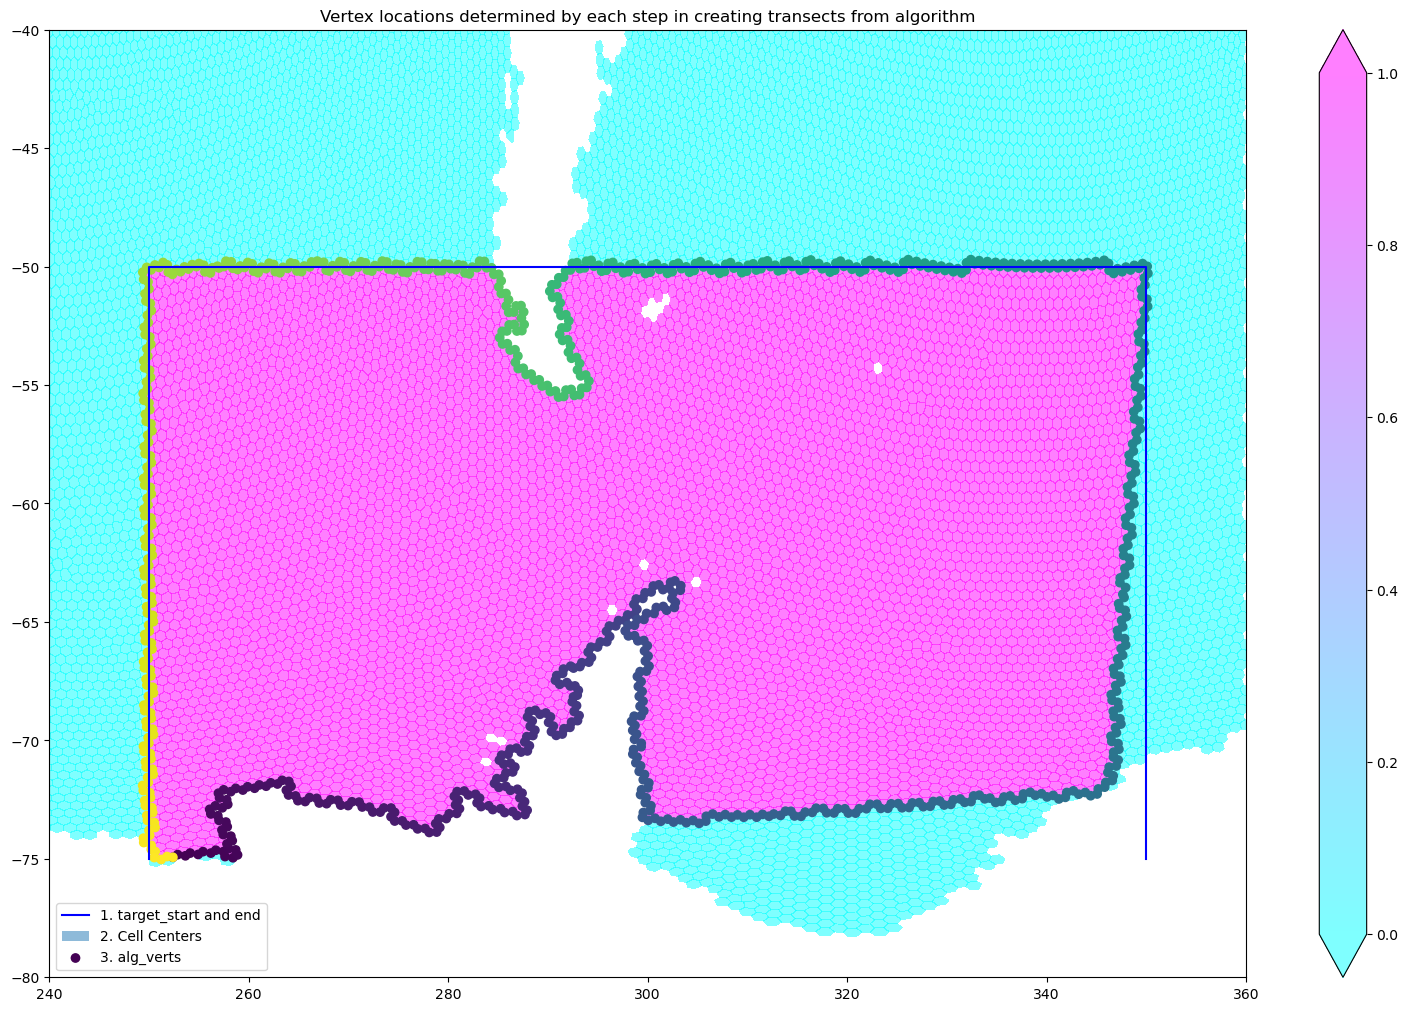

In [26]:
# plot this masked region
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# LS the target start and end points when creating the algorithm
ax.plot(lons, lats, color='blue',label='1. target_start and end')

# plot the cellmask created from the cell centers in the mask (id'd with MPAS-tools)
# we don't need to worry about the mps.find_and_sort_transect_edges_and_vertices function because 
# the cell centers will always be inside the mask
# create cellmasks (which cells centers are included in the masked region)

cellmask = mask.regionCellMasks.isel(nRegions=0).astype(bool)
c = mosaic.polypcolor(ax,descriptor,
                  cellmask.astype(int),cmap='cool',alpha = 0.5,
                  antialiaseds=False, label = '2. Cell Centers')

fig.colorbar(c, extend='both')

# LS (lats and lons of vertices from transect)
# ax.scatter(test_verts_lons + 360,test_verts_lats, s=60,marker='^',color='orange',label='3. test_verts')


# plot using vertex lats and lons (removed vertices on cells not in the mask)
vertex_lons = ds.lonVertex.isel(nVertices = alg_vertices) * 180 / np.pi
vertex_lats = ds.latVertex.isel(nVertices = alg_vertices) * 180 / np.pi

# plot the vertices after removing where there are duplicates. 
# the colorbar shows the index of the lons and lats for each vertex 
# (since it is a gradient --> the vertex lats and lons are in order)
ax.scatter(vertex_lons,vertex_lats,c=np.arange(0,len(vertex_lons)),label='3. alg_verts')

ax.set_ylim(-80,-40)
ax.set_xlim(240,360)

ax.set_title('Vertex locations determined by each step in creating transects from algorithm')
ax.legend()

#fig.suptitle('Grid variables from mask made from transect algorithm + MPAS-Tools')

### where even are these remaining edges

(-1.32, -0.85)

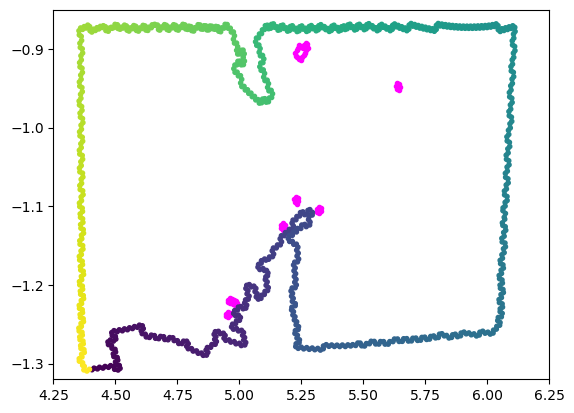

In [222]:
re_mesh_transectEdges = mesh.isel(nEdges = np.int32(remaining_edges))
plt.scatter(re_mesh_transectEdges.lonEdge, re_mesh_transectEdges.latEdge, marker = '.',c='magenta')
plt.scatter(mesh_transectVertices.lonVertex, mesh_transectVertices.latVertex, marker = '.', c=mesh_transectVertices.sorted_vertices)

plt.xlim(4.25,6.25)
plt.ylim(-1.32,-0.85)

### before sorting algorithm

In [223]:
ba_mesh_transectEdges = mesh.isel(nEdges = np.int32(xr_mask_transect_edges))
ba_mesh_transectEdges['sorted_edges'] = ba_mesh_transectEdges.lonEdge * 0
for i in range(0,len(next_edges)):
    ba_mesh_transectEdges['sorted_edges'][i] = ba_mesh_transectEdges.sorted_edges[i] + i

(-1.32, -0.85)

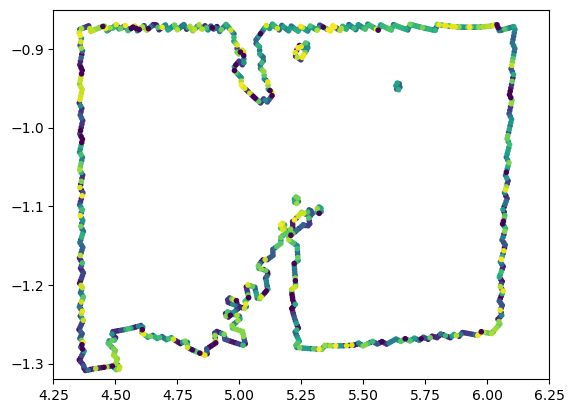

In [224]:
plt.scatter(ba_mesh_transectEdges.lonEdge, ba_mesh_transectEdges.latEdge, marker='.', c= ba_mesh_transectEdges.sorted_edges)
plt.xlim(4.25,6.25)
plt.ylim(-1.32,-0.85)

In [225]:
ba_mesh_transectVertices = mesh.isel(nVertices = xr_mask_transect_vertices)
ba_mesh_transectVertices['sorted_vertices'] = ba_mesh_transectVertices.lonVertex * 0
for i in range(0,len(next_vertices)):
    ba_mesh_transectVertices['sorted_vertices'][i] = ba_mesh_transectVertices.sorted_vertices[i] + i

(-1.32, -0.85)

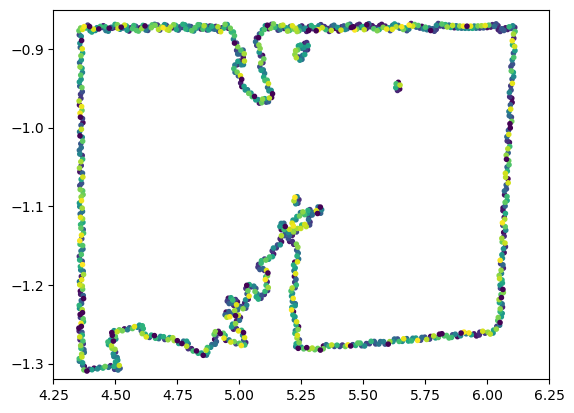

In [226]:
plt.scatter(ba_mesh_transectVertices.lonVertex, ba_mesh_transectVertices.latVertex, marker = '.', c=ba_mesh_transectVertices.sorted_vertices)
plt.xlim(4.25,6.25)
plt.ylim(-1.32,-0.85)

### after sorting algorithm

In [227]:
mesh_transectEdges = mesh.isel(nEdges = np.int32(next_edges))
mesh_transectEdges['sorted_edges'] = mesh_transectEdges.lonEdge * 0
for i in range(0,len(next_edges)):
    mesh_transectEdges['sorted_edges'][i] = mesh_transectEdges.sorted_edges[i] + i

(-1.32, -0.85)

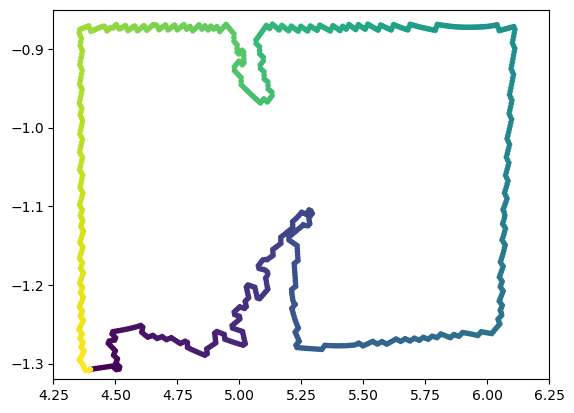

In [228]:
plt.scatter(mesh_transectEdges.lonEdge, mesh_transectEdges.latEdge, marker='.', c= mesh_transectEdges.sorted_edges)
plt.xlim(4.25,6.25)
plt.ylim(-1.32,-0.85)

In [230]:
mesh_transectVertices = mesh.isel(nVertices = np.int32(next_vertices))
mesh_transectVertices['sorted_vertices'] = mesh_transectVertices.lonVertex * 0
for i in range(0,len(next_vertices)):
    mesh_transectVertices['sorted_vertices'][i] = mesh_transectVertices.sorted_vertices[i] + i

(-1.32, -0.85)

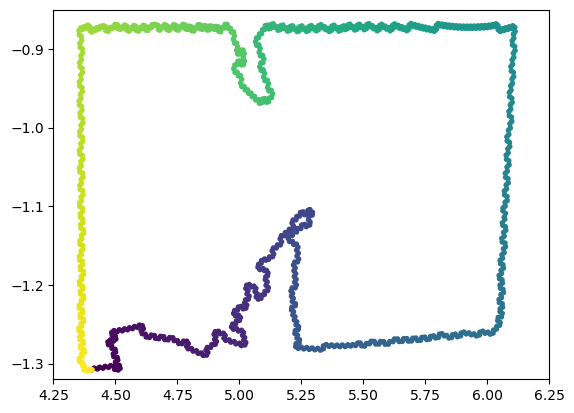

In [231]:
plt.scatter(mesh_transectVertices.lonVertex, mesh_transectVertices.latVertex, marker = '.', c=mesh_transectVertices.sorted_vertices)
plt.xlim(4.25,6.25)
plt.ylim(-1.32,-0.85)

In [ ]:
xr_mask_transect_vertices

In [ ]:
np.intersect1d(remaining_edges, xr_edgesOnStartVertex + 1)

In [ ]:
remaining_edges

In [ ]:
xr_edgesOnStartVertex + 1

In [ ]:
remaining_edges

In [ ]:
path = './'
filename = 'SO_region_test'
geojson_file_name = 'Southern Ocean region encomapssing Drake passage from transect algorithm'
tags = "Southern_Ocean"
author = "Kaila Uyeda"

lats = np.array([-75,-50,-50,-75])
lons = np.array([250, 250, 350, 350])

alg_edges, alg_vertices, dsMasks = open_transect_from_alg(ds, lats, lons, path, filename, geojson_file_name, tags, author)

In [ ]:
def open_from_mask(ds):
    # open mask of desired region (this is to find transects from a pre-existing mask)
    path = './'
    filename = 'LS_test_transect_from_mask'
    
    check_nc_existence = os.path.isfile(path + filename + '.nc')
    
    # check if .nc mask file exists
    if check_nc_existence == True:
        print(f'Opening {filename}.nc file as mask')
        mask = xr.open_dataset(path + filename + '.nc')
    else: 
        print('Creating .nc file')
        check_geojson_existence = os.path.isfile(path + filename + '.geojson')
    
        # convert LS_test.geojson to LS_test.nc mask file
        if check_geojson_existence == True:
            print(f'Using {filename}.geojson to create .nc file')
            fcMask = read_feature_collection(path + filename + '.geojson')
            # pool = create_pool(process_count=8)
            pool=None
            dsMasks = compute_mpas_region_masks(ds, fcMask, maskTypes =('cell',), pool=pool)
            dsMasks.to_netcdf(path + filename + '.nc', format='NETCDF4', mode='w')
            mask = xr.open_dataset(path + filename + '.nc')
            print(f'{filename}.nc created and opened as masks')
        else:
            print(f'{filename}.geojson does NOT exist!')
    
    mask_edges, mask_vertices = find_and_sort_transect_edges_and_vertices(ds,mask)

    return mask_edges, mask_vertices, mask

### choose how you want to make transect and mask

In [ ]:
# get edges and vertices of mask made from transect from algorithm
alg_edges, alg_vertices, dsMasks = mps.open_transect_from_alg(mesh)

# get edges and vertices of mask made from mask
mask_edges, mask_vertices, mask = mps.open_from_mask(mesh)

# Set up choice of coordinates

In [ ]:
method = 'alg' # 'mask'
if method == 'alg':
    edges, vertices = alg_edges, alg_vertices
    mask = dsMasks

if method == 'mask':
    edges, vertices = mask_edges, mask_vertices
    mask = mask

In [ ]:
# xr_cellsOnTransectEdges, dss_transect_edges = mps.format_transect_data(ds,edges)

In [ ]:
# dss_transect_edges_vIM = mps.calculate_velo_into_mask(dss_transect_edges, xr_cellsOnTransectEdges, ds, mask, edges)

In [ ]:
# dss_transect_edges_vIM = mps.calculate_transport_into_mask(dss_transect_edges_vIM)

In [ ]:
# dss_transect_edges_vIM, transport_transformed_cons = mps.transport_in_density_coords(dss_transect_edges_vIM, target_coords)

In [ ]:
# def transport_in_density_space_from_ds(ds, edges, mask, target_coords):
#     xr_cellsOnTransectEdges , dss_transect_edges = mps.format_transect_data(ds, edges)
#     dss_transect_edges_vIM = mps.calculate_velo_into_mask(dss_transect_edges, xr_cellsOnTransectEdges, ds, mask, edges) 
#     dss_transect_edges_vIM = mps.calculate_transport_into_mask(dss_transect_edges_vIM)
#     dss_transect_edges_vIM, transport_transformed_cons = mps.transport_in_density_coords(dss_transect_edges_vIM, target_coords)

#     return dss_transect_edges_vIM, transport_transformed_cons

In [ ]:
target_coords = np.linspace(1022,1029,100)
dss_transect_edges_vIM, transport_transformed_cons = mps.transport_in_density_space_from_ds(ds,edges, mask, target_coords)

In [ ]:
total_transport_Edge = transport_transformed_cons.sum('nEdges').mean(dim=['xtime_startMonthly','TWO'])

In [ ]:
total_transport_Edge

In [ ]:
# we want to cumsum from bottom to top

# flip the array so bottom is now the first index
np.flipud(total_transport_Edge)

# cumsum this new array (this cumsums bottom (index=0) to top (index=49)
np.flipud(total_transport_Edge).cumsum()

# flip the array again to get cumsum bottom values back at the last index
cs_total_transport_Edge = np.flipud(np.flipud(total_transport_Edge).cumsum(axis=0))

plt.plot(cs_total_transport_Edge, target_coords[0:99],marker='.')
plt.gca().invert_yaxis()
plt.plot(np.zeros(2), np.array([1022,1028]))